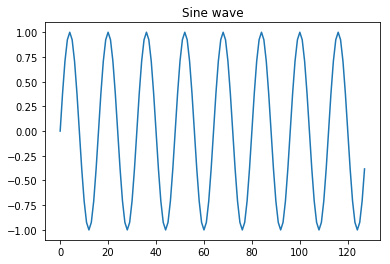

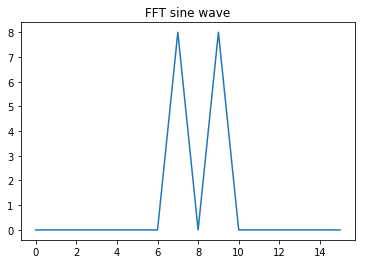

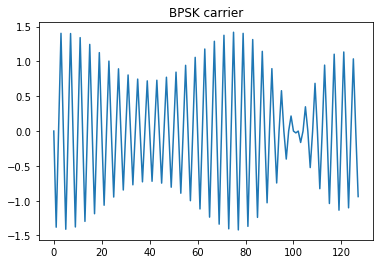

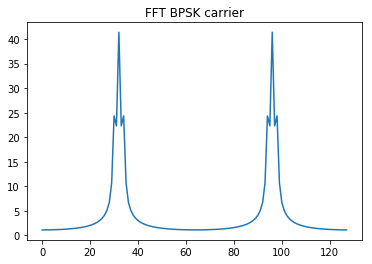

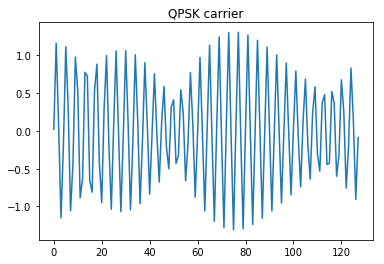

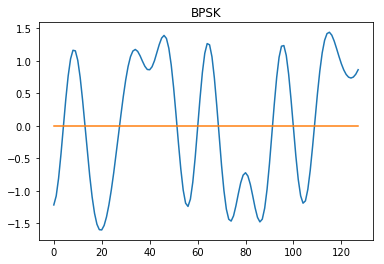

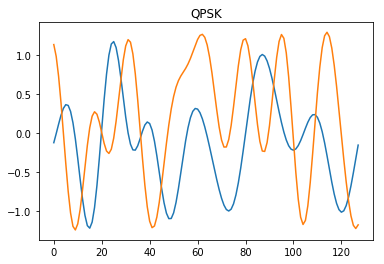

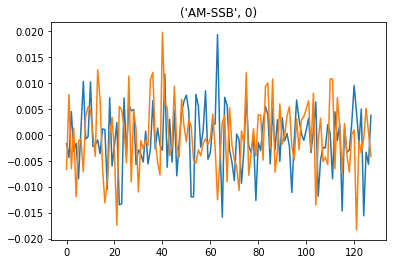

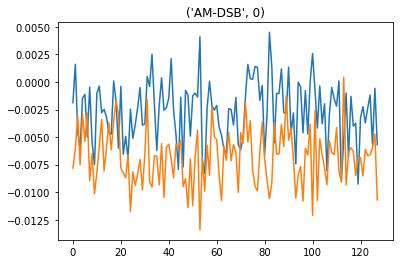

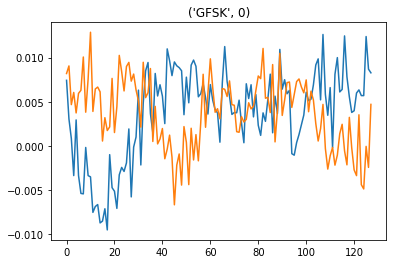

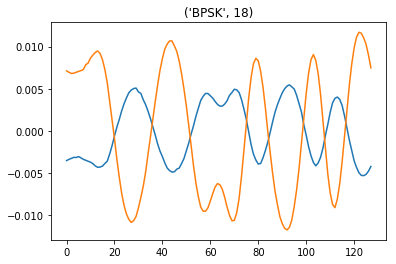

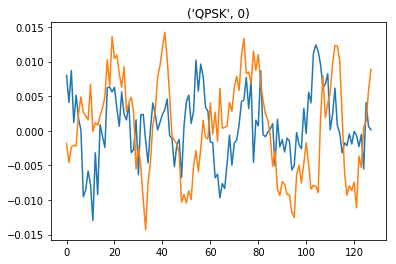

In [1]:
import numpy as np
from scipy import pi
import matplotlib.pyplot as plt
import pickle as cPickle
#Sine wave

N = 128

def get_sine_wave():
    x_sin = np.array([0.0 for i in range(N)])
    # print(x_sin)
    for i in range(N):
        # print("h")
        x_sin[i] = np.sin(2.0*pi*i/16.0)

    plt.plot(x_sin)
    plt.title('Sine wave')
    plt.show()

    y_sin = np.fft.fftshift(np.fft.fft(x_sin[:16], 16))
    plt.plot(abs(y_sin))
    plt.title('FFT sine wave')
    plt.show()

    return x_sin

def get_bpsk_carrier():
    x = np.fromfile('gnuradio_dumps/bpsk_carrier', dtype = 'float32')
    x_bpsk_carrier = x[9000:9000+N]
    plt.plot(x_bpsk_carrier)
    plt.title('BPSK carrier')
    plt.show()
    
    y_bpsk_carrier =  np.fft.fft(x_bpsk_carrier, N)
    plt.plot(abs(y_bpsk_carrier))
    plt.title('FFT BPSK carrier')
    plt.show()
    
    return x_bpsk_carrier


def get_qpsk_carrier():
    x = np.fromfile('gnuradio_dumps/qpsk_carrier', dtype = 'float32')
    x_qpsk_carrier = x[12000:12000+N]
    plt.plot(x_qpsk_carrier)
    plt.title('QPSK carrier')
    plt.show()


    # y_qpsk_carrier =  np.fft.fft(x_qpsk_carrier, N)
    # plt.plot(abs(y_qpsk_carrier))
    # plt.title('FFT QPSK carrier')
    # plt.show()
    
    return x_qpsk_carrier

def get_bpsk():
    x = np.fromfile('gnuradio_dumps/bpsk', dtype = 'complex64')
    x_bpsk = x[9000:9000+N]
    plt.plot(x_bpsk.real)
    plt.plot(x_bpsk.imag)
    plt.title('BPSK')
    plt.show()



    # y_bpsk =  np.fft.fft(x_bpsk, N)
    # plt.plot(abs(y_bpsk))
    # plt.title('FFT BPSK')
    # plt.show()
    
    return x_bpsk

def get_qpsk():
    x = np.fromfile('gnuradio_dumps/qpsk', dtype = 'complex64')
    x_qpsk = x[11000:11000+N]
    plt.plot(x_qpsk.real)
    plt.plot(x_qpsk.imag)
    plt.title('QPSK')
    plt.show()



    # y_qpsk =  np.fft.fft(x_bpsk, N)
    # plt.plot(abs(y_bqsk))
    # plt.title('FFT QPSK')
    # plt.show()
    
    return x_qpsk

def load_dataset(location="../../datasets/radioml.dat"):
    f = open(location, "rb")
    ds = cPickle.load(f, encoding = 'latin-1')
    return ds


def get_from_dataset(dataset, key):
    """Returns complex version of dataset[key][500]"""
    xr = dataset[key][500][0]
    xi = dataset[key][500][1]
    plt.plot(xr)
    plt.plot(xi)
    plt.title(key)
    plt.show()
    return xr+1j*xi

x_sin = get_sine_wave()
x_bpsk_carrier = get_bpsk_carrier()
x_qpsk_carrier = get_qpsk_carrier()
x_bpsk = get_bpsk()
x_qpsk = get_qpsk()

ds = load_dataset(location="../modulation_recognition/RML2016.10a_dict.dat")
x_amssb = get_from_dataset(dataset=ds, key=('AM-SSB', 0))
x_amdsb = get_from_dataset(dataset=ds, key= ('AM-DSB', 0))
x_gfsk = get_from_dataset(dataset=ds, key=('GFSK', 0))
x_bpsk_dataset = get_from_dataset(dataset=ds, key = ('BPSK',18))
x_qpsk_dataset = get_from_dataset(dataset=ds, key = ('QPSK',0))



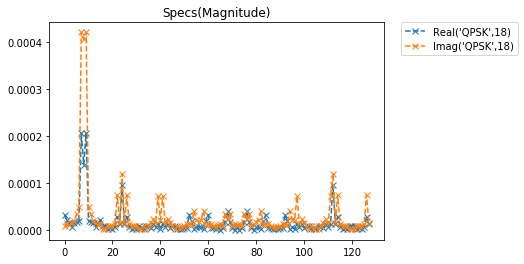

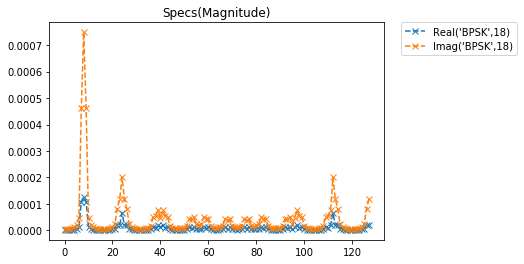

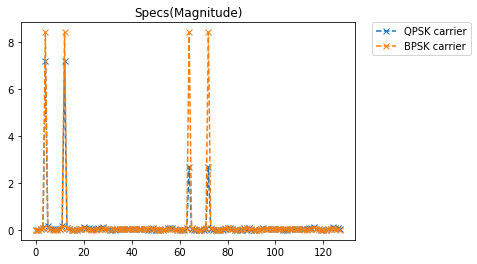

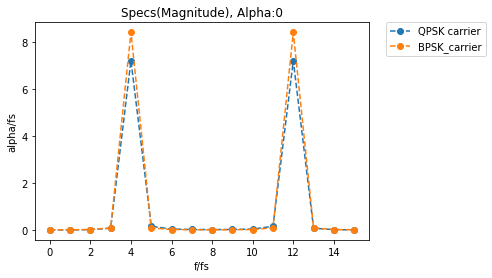

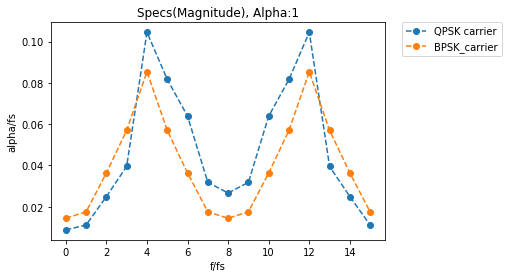

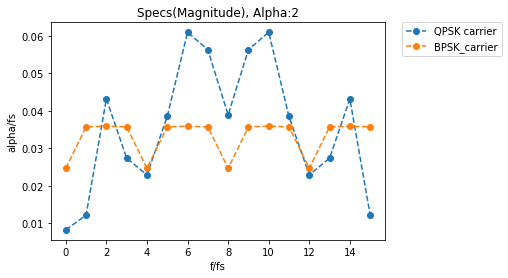

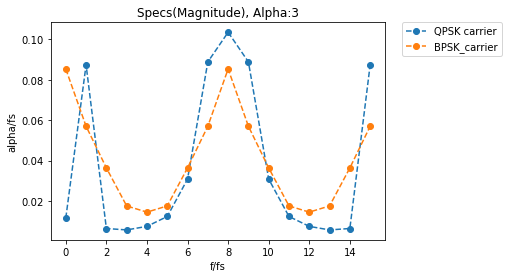

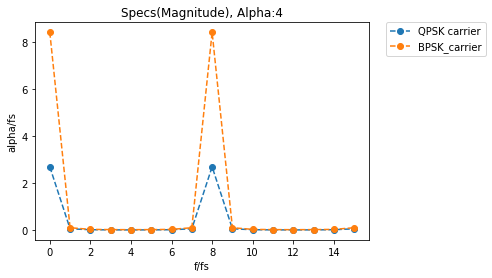

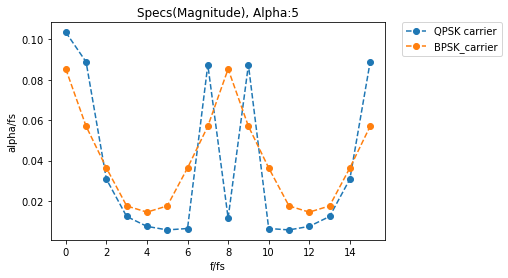

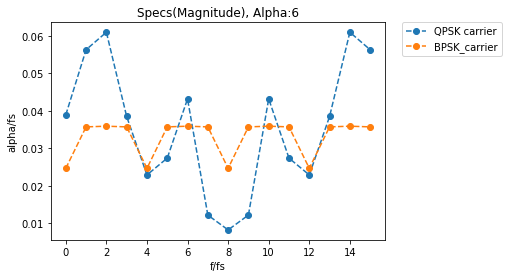

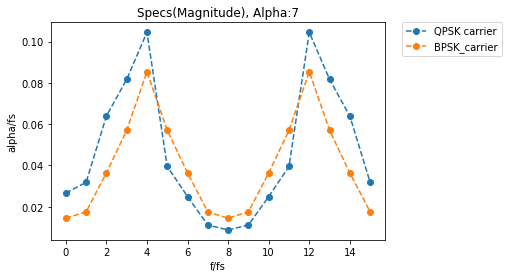

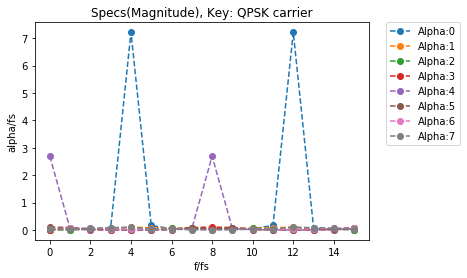

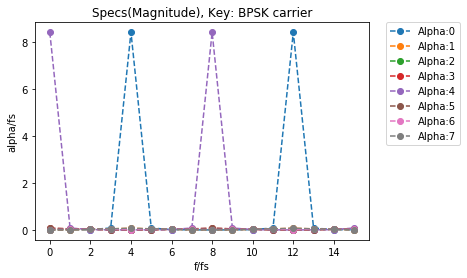

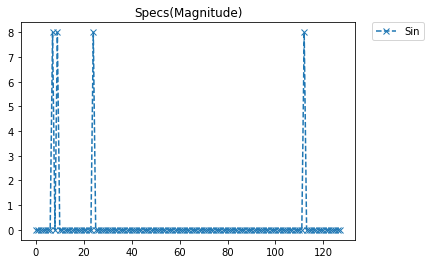

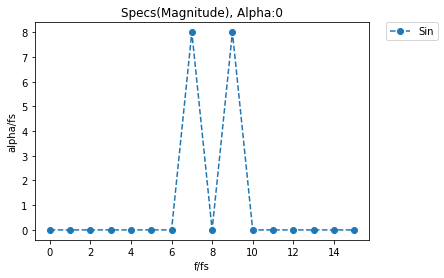

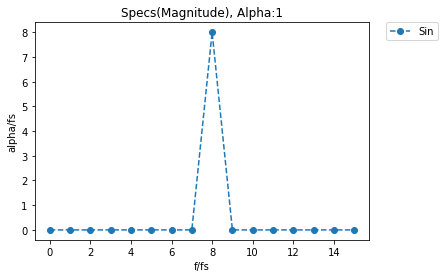

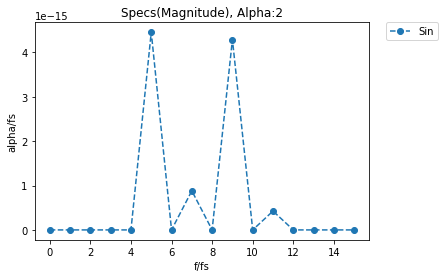

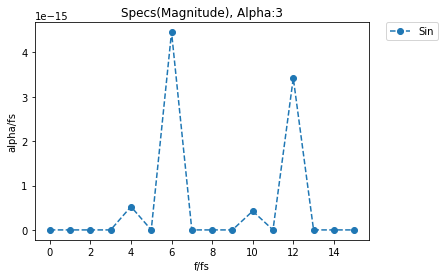

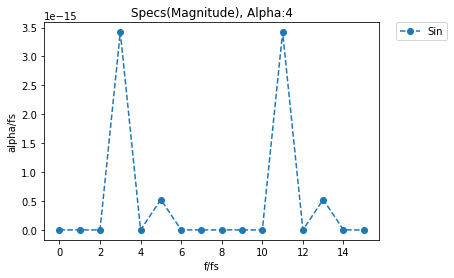

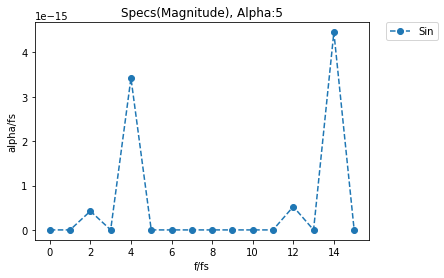

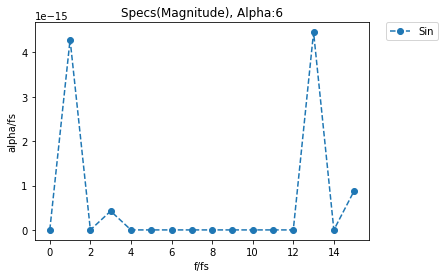

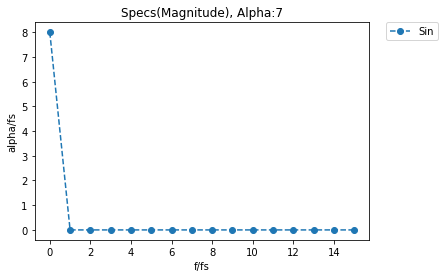

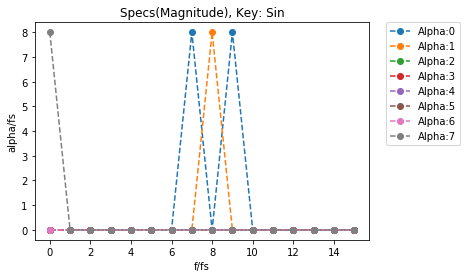

In [2]:
nfft = 16
cyclo_averaging = 8
offsets = [0,1,2,3,4,5,6,7]
zero_threshold = 1e-3

def round_to_zero(data, zero_threshold):
    '''Set entries with absolute values below threshold to zero'''
    data_rounded = data
    for k,s in enumerate(data):
        if abs(s) < zero_threshold:
            data_rounded[k] = 0
    return data_rounded
    
def compute_cyclo_fft(data, nfft):  
    '''
    Split data into blocks of size nfft and compute fft for each block       
    Input:data: length N (say), 
          nfft: size of fft
    Output: nfft x N/nfft size matrix where jth column contains fft of jth block
    '''

    data_reshape = np.reshape(data, (-1, nfft))    
    y =  np.fft.fftshift(np.fft.fft(data_reshape, axis=1), axes=1)  
#     plt.plot(data_reshape[0,:].real)
#     plt.title('Sample Data ' + str(nfft) + ' points')
#     plt.show()
    return y.T


def compute_correlation(x,y):
    '''
    Input: x and y are arrays to be correlated
    Output: inner product of x and y divided by length of x'''
    x = np.reshape(x, [-1,])
    y = np.reshape(y, [-1,])
    lenx = x.shape[0]
    corr = 0
    for i in range(lenx):
        corr += x[i]*np.conj(y[i])        
    corr /= lenx
    return corr

def compute_coefficients(cyc_fft, alphas):
    '''
    Input:nfft X cyclo_averaging size matrix where jth column is fft of a sample
    Output:specs: nfft X num_offsets size matrix where jth column contains spectral coefficients corresponding to its alpha(offset)
           scs: nfft X num_offsets size matrix where jth column contains scaled spectral coefficients corresponding to its alpha(offset)
    The spectral coefficients close to 0 are set to exactly zero before scaling to obtain scs
    '''       

    specs = np.zeros((nfft,len(alphas)), dtype=np.complex)
    scs = np.zeros((nfft,len(alphas)),dtype=np.complex)
    for alpha in alphas:
        z = np.array(np.zeros(cyc_fft.shape), dtype=np.complex)
        denom_right = np.zeros(cyc_fft.shape, dtype=np.complex)
        denom_left = np.zeros(cyc_fft.shape,dtype=np.complex)        
        for i in range(cyc_fft.shape[1]):
            x = cyc_fft[:,i]
            x_right = np.roll(x, alpha)
            x_left = np.roll(x, -alpha)
            z[:,i] = (x_right*np.conj(x_left))/cyc_fft.shape[1]
            
            
            
            denom_right[:,i] =(x_right*np.conj(x_right)/cyc_fft.shape[1])
            denom_left[:,i] = (x_left*np.conj(x_left)/cyc_fft.shape[1])            
            spec = np.mean(z,axis=1)   
            denom = np.sqrt(np.abs(np.mean(denom_right, axis=1))*np.abs(np.mean(denom_left,axis=1)))
           
            specs[:,alpha] = spec
            spec = round_to_zero(spec, zero_threshold)           
            sc = spec/denom
            scs[:,alpha] = sc 
            
    return specs, scs

def cyclo_stationary(data):
    cyc_fft = compute_cyclo_fft(data, nfft)  
    specs, scs = compute_coefficients(cyc_fft,alphas = offsets)
    return specs, scs    

def convert_to_1d(data_2d):
    '''Stacks columns below each other'''
    M,N= data_2d.shape
    data_1d = np.zeros((M*N,),dtype=np.complex)
    for i in range(N):
        data_1d[i*M:(i+1)*M] = data_2d[:,i]        
    return data_1d

def visualize_2d(data_list, key_list, title, alphas, group='key'):  
    '''
    If group is 'key' for each alpha plot specs for all keys in one plot
    If group is 'alpha' for each key plot specs for all alphas in one plot
    '''
    if group == 'key':
        for alpha in alphas:
            for k,data in enumerate(data_list):
                key = key_list[k]
                plt.plot(abs(data[:,alpha]), 'o--', label = key)            
            plt.title(title+', Alpha:' + str(alpha))        
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.xlabel('f/fs')
            plt.ylabel('alpha/fs')
            plt.show() 
    elif group == 'alpha':
        for k,key in enumerate(key_list):
            data = data_list[k]
            for alpha in alphas:
                plt.plot(abs(data[:,alpha]), 'o--', label='Alpha:' +str(alpha))
            plt.title(title + ', Key: ' + str(key))
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.xlabel('f/fs')
            plt.ylabel('alpha/fs')
            plt.show() 

def visualize_1d(data_list, key_list, title):
    for k,data in enumerate(data_list):
        key = key_list[k]        
        plt.plot(abs(data), 'x--', label = str(key))
    plt.title(title)    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


#Dataset QPSk
specs_2d_qpsk_real,scs_2d_qpsk_real = cyclo_stationary(x_qpsk_dataset.real)
specs_1d_qpsk_real = convert_to_1d(specs_2d_qpsk_real)
specs_2d_qpsk_imag,scs_2d_qpsk_imag = cyclo_stationary(x_qpsk_dataset.imag)
specs_1d_qpsk_imag= convert_to_1d(specs_2d_qpsk_imag)
visualize_1d(data_list=[specs_1d_qpsk_real, specs_1d_qpsk_imag], key_list=["Real('QPSK',18)", "Imag('QPSK',18)" ], title='Specs(Magnitude)')

#Dataset BPSK
specs_2d_bpsk_real,scs_2d_bpsk_real = cyclo_stationary(x_bpsk_dataset.real)
specs_1d_bpsk_real = convert_to_1d(specs_2d_bpsk_real)
specs_2d_bpsk_imag,scs_2d_bpsk_imag = cyclo_stationary(x_bpsk_dataset.imag)
specs_1d_bpsk_imag= convert_to_1d(specs_2d_bpsk_imag)
visualize_1d(data_list=[specs_1d_bpsk_real, specs_1d_bpsk_imag],  key_list=["Real('BPSK',18)", "Imag('BPSK',18)" ],  title='Specs(Magnitude)')


#BPSK,QPSK at carrier
specs_2d_bpsk_carrier,scs_2d_bpsk_carrier = cyclo_stationary(x_bpsk_carrier)
specs_1d_bpsk_carrier = convert_to_1d(specs_2d_bpsk_carrier)
specs_2d_qpsk_carrier,scs_2d_qpsk_carrier = cyclo_stationary(x_qpsk_carrier)
specs_1d_qpsk_carrier = convert_to_1d(specs_2d_qpsk_carrier)
visualize_1d(data_list=[specs_1d_qpsk_carrier, specs_1d_bpsk_carrier], key_list=["QPSK carrier", "BPSK carrier"], title = 'Specs(Magnitude)')
visualize_2d(data_list = [specs_2d_qpsk_carrier, specs_2d_bpsk_carrier], key_list=["QPSK carrier", "BPSK_carrier"], title = 'Specs(Magnitude)', alphas = offsets, group = 'key')
visualize_2d(data_list = [specs_2d_qpsk_carrier, specs_2d_bpsk_carrier ],  key_list=["QPSK carrier", "BPSK carrier"], title = 'Specs(Magnitude)', alphas = offsets, group = 'alpha')

#Sine wave
specs_2d_sin,scs_2d_sin = cyclo_stationary(x_sin.real)
specs_1d_sin = convert_to_1d(specs_2d_sin)
visualize_1d(data_list=[specs_1d_sin],  key_list=["Sin" ],  title='Specs(Magnitude)')
visualize_2d(data_list = [specs_2d_sin], key_list=["Sin"], title = 'Specs(Magnitude)', alphas = offsets, group = 'key')
visualize_2d(data_list = [specs_2d_sin], key_list=["Sin"], title = 'Specs(Magnitude)', alphas = offsets, group = 'alpha')


<h1> Classification onwards from here </h1>

In [3]:
from sklearn import svm

In [4]:
ds = load_dataset(location="../modulation_recognition/RML2016.10a_dict.dat")
bpsk_18 = ds[("BPSK", 18)]
qpsk_18 = ds[("QPSK", 18)]
classes = {"bpsk": 0, "qpsk": 1}

In [15]:
def wrapper_cyclo(data):
    """Presumes data is n datapoints."""
    n, _ = data.shape
    specs = np.zeros((n, 128))
    for i in range(n):
        a, _ = cyclo_stationary(data[i, :])
        specs[i, :] = convert_to_1d(a)
    return specs

In [35]:
snr_vals = list(map(lambda a: a[1], list(filter(lambda a:a[0] == 'BPSK' and a[1] != 18, list(ds.keys()), ))))
bpsk = ds[("BPSK", 18)]
qpsk = ds[("QPSK", 18)]
for i in snr_vals:
    bpsk = np.vstack([ds[("BPSK", i)], bpsk])
    qpsk = np.vstack([ds[("QPSK", i)], qpsk])

In [36]:
bpsk = np.add(bpsk[:, 0, :], 1j*bpsk[:, 1, :])
qpsk = np.add(qpsk[:, 0, :], 1j*qpsk[:, 1, :])
bpsk_features = wrapper_cyclo(bpsk)
qpsk_features = wrapper_cyclo(qpsk)

/Users/NJ/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


In [51]:
def create_train_test(data1, data2):
    training_set = 0.7
    n, _ = data1.shape
    num_train = int(n * training_set)

    np.random.shuffle(data1)
    np.random.shuffle(data2)

    train_q = data1[:num_train, ]
    train_b = data2[:num_train, ]
    test_q = data1[num_train:, ]
    test_b = data2[num_train:, ]

    train_x = np.vstack((train_q, train_b))
    train_y = np.vstack((np.zeros((num_train, 1)), np.ones((num_train, 1)))) # data1 - 0, data2 - 1

    test_x = np.vstack((test_q, test_b))
    test_y = np.vstack((np.zeros((n - num_train, 1)), np.ones((n - num_train, 1))))

    # Time to mix the data
    together = np.hstack((train_x, train_y))
    np.random.shuffle(together)
    train_x, train_y = np.hsplit(together, [together.shape[1] - 1])

    together = np.hstack((test_x, test_y))
    np.random.shuffle(together)
    test_x, test_y = np.hsplit(together, [together.shape[1] - 1])
    return train_x, train_y, test_x, test_y

In [52]:
def percentage_success(actual, predicted):
    return 1 - (np.linalg.norm(actual - predicted)**2 / (predicted.shape[0]))

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

def gamut_classification(train_x, train_y, test_x, test_y):
    clf = SVC(C = 1.0, kernel='poly')
    clf.fit(train_x, train_y)
    predicted = clf.predict(test_x).reshape((-1, 1))
    print("Polynomial Kernel, SVM ", percentage_success(test_y, predicted))
    clf = SVC(C = 1.0, kernel='rbf')
    clf.fit(train_x, train_y)
    predicted = clf.predict(test_x).reshape((-1, 1))
    print("RBF Kernel, SVM ", percentage_success(test_y, predicted))
    clf = SVC(C = 1.0, kernel='linear')
    clf.fit(train_x, train_y)
    predicted = clf.predict(test_x).reshape((-1, 1))
    print("Linear Kernel, SVM ", percentage_success(test_y, predicted))
    clf = RandomForestClassifier(max_depth=2, n_estimators=100)
    clf.fit(train_x, train_y)
    predicted = clf.predict(test_x).reshape((-1, 1))
    print("Random Forests ", percentage_success(test_y, predicted))
    clf = AdaBoostClassifier(n_estimators=100)
    clf.fit(train_x, train_y)
    predicted = clf.predict(test_x).reshape((-1, 1))
    print("AdaBoost ", percentage_success(test_y, predicted))

In [53]:
train_x, train_y, test_x, test_y = create_train_test(bpsk_features, qpsk_features)
gamut_classification(train_x, train_y, test_x, test_y)

/Users/NJ/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Polynomial Kernel, SVM  0.50475
RBF Kernel, SVM  0.500083333333
Linear Kernel, SVM  0.500083333333


/Users/NJ/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forests  0.580666666667


/Users/NJ/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost  0.626416666667


# We have the following results for QPSK vs BPSK:
## Polynomial Kernel, SVM  0.50475
## RBF Kernel, SVM  0.500083333333
## Linear Kernel, SVM  0.500083333333
## Random Forests  0.580666666667
## AdaBoost  0.626416666667

In [57]:
# Normalization functions
def normalize(data):
    # Normalizes the norm of the entire vector to 1
    data = data.copy()
    n, _  = data.shape
    if n == 1:
        return singular_normalize(data)
    
    for i in range(n):
        data[i, :] = singular_normalize(data[i, :])
        
    return data
    
def singular_normalize(data_vector):
    # Normalizes one vector to 1
    norm = np.linalg.norm(data_vector)
    return data_vector / norm

# Let us generate AWGN, unit variance, normalize, and compare classification

In [58]:
awgn_data = normalize(np.random.normal(0, 1, (20000, 128)))
awgn_features = wrapper_cyclo(awgn_data)

/Users/NJ/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


In [59]:
train_x, train_y, test_x, test_y = create_train_test(bpsk_features, awgn_features)
gamut_classification(train_x, train_y, test_x, test_y)

/Users/NJ/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Polynomial Kernel, SVM  1.0
RBF Kernel, SVM  1.0
Linear Kernel, SVM  1.0


/Users/NJ/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forests  1.0


/Users/NJ/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost  1.0
